# EXERCÍCIO 3: Classificadores Bayesianos

### Objetivos

Neste Notebook apresentaremos a aplicação dos classicadores de Bayes, sendo eles o Bayesiano tradicional, o não paramétrico e o de Naive-Bayes.

Primeiramente, começamos aplicando-os a um mesmo dataset, e observando qual melhor classifica entre esses 3 métodos

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.metrics import accuracy_score
from scipy.stats import multivariate_normal

random.seed(42) # Definindo uma seed para reprodutibilidade

# Carregando os dados
data = pd.read_csv('data/vertebralcolumn-2C.csv', header=(0))

# Separando atributos e classes da tabela e convertendo para numpy arrays
y = data.iloc[:,-1]
classes = np.array(pd.unique(y))
data = data.to_numpy()
nrow,ncol = data.shape
X = data[:,0:ncol-1]

p = 0.7 # fracao de elementos no conjunto de treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

# MÉTODO 1: BAYESIANO TRADICIONAL

# Matriz para armazenar as probabilidades
P = pd.DataFrame(data=np.zeros((X_test.shape[0], len(classes))), columns = classes) 
Pc = np.zeros(len(classes)) # Fração de elementos em cada classe
for i in np.arange(0, len(classes)):
    elements = np.array(np.where(y_train == classes[i]))
    Pc[i] = elements.shape[1]/len(y_train)
    Z = X_train[elements,:][0].astype(float)
    m = np.mean(Z, axis = 0)
    cv = np.cov(np.transpose(Z))
    for j in np.arange(0,X_test.shape[0]):
        x = X_test[j,:]
        pj = multivariate_normal.pdf(x, mean=m, cov=cv, allow_singular=True)
        P.loc[j, classes[i]] = pj*Pc[i] # Teorema de Bayes

y_pred = []
for i in np.arange(0, X_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])
y_pred = np.array(y_pred)
y_test = np.array(y_test)

score = accuracy_score(y_pred, y_test)
print('Traditional Bayes Accuracy:', score)

# Acurácia do Bayesiano tradicional  = 0.8064516129032258 

# MÉTODO 2: BAYESIANO NÃO PARAMÉTRICO

# Usando KDE para estimar as densidades (importado do sklearn)
h = 0.5  # parametro de largura de banda
kdes = {}
for c in classes:
    X_c = X_train[y_train == c]
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(X_c)
    kdes[c] = kde

# Prevendo usendo o teorema de Bayes 
y_pred_kde = []
for x in X_test:
    probs = []
    for c in classes:
        # Implementação em código de P(x|c) * P(c)
        log_likelihood = kdes[c].score_samples(x.reshape(1, -1))
        prior = np.sum(y_train == c) / len(y_train)
        probs.append(np.exp(log_likelihood) * prior)
    y_pred_kde.append(classes[np.argmax(probs)])

score_kde = accuracy_score(y_pred_kde, y_test)
print('Non-parametyric Bayes Accuracy:', score_kde)

# Acurácia do Bayesiano não paramétrico = 0.8387096774193549

# MÉTODO 3: MÉTODO DE NAIVE BAYES

def likelihood(x, X_class):
    prob = 1
    for j in range(X_class.shape[1]):
        mean = np.mean(X_class[:, j])
        std = np.std(X_class[:, j])
        prob *= (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-((x[j] - mean) ** 2) / (2 * std ** 2))
    return prob

# Cauculando predições
y_pred_naive = []
for x in X_test:
    probs = []
    for c in classes:
        X_class = X_train[y_train == c]
        # Calculando P(x|c) * P(c)
        prior = np.sum(y_train == c) / len(y_train)
        prob = likelihood(x, X_class) * prior
        probs.append(prob)
    y_pred_naive.append(classes[np.argmax(probs)])

NB_score = accuracy_score(y_pred_naive, y_test)
print('Naive Bayes accuracy:', NB_score)

# Acurácia do Naive Bayes = 0.7956989247311828

Traditional Bayes Accuracy: 0.8064516129032258
Non-parametyric Bayes Accuracy: 0.8387096774193549
Naive Bayes accuracy: 0.7956989247311828


### Procurando um hiperparâmetro ideal

No método de Bayes não paramétrica, temos que predefinir um hiperparametro h (largura de banda), antes de fazermos a classificação, sendo que esse hiperparametro acaba alterando nosso resultado final. Nessa próxima sessão tentamos encontrar qual hiperparametro melhor classifica nosso dataset, ou seja, possui a maior acurácie entre todos as larguras de bandas testadas.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Carregando os dados
data = pd.read_csv('data/winequality-red.csv', header=(0))

# Separando atributos e classes da tabela e convertendo para numpy arrays
y = data.iloc[:,-1]
classes = np.array(pd.unique(y))
data = data.to_numpy()
nrow,ncol = data.shape
X = data[:,0:ncol-1]

p = 0.7 # fracao de elementos no conjunto de treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

# Usando KDE para estimar as densidades (importado do sklearn)
h = 0.052  # parametro de largura de banda encontradop por tentativa e erro
kdes = {}
for c in classes:
    X_c = X_train[y_train == c]
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(X_c)
    kdes[c] = kde

# Prevendo usendo o teorema de Bayes 
y_pred_kde = []
for x in X_test:
    probs = []
    for c in classes:
        # Implementação em código de P(x|c) * P(c)
        log_likelihood = kdes[c].score_samples(x.reshape(1, -1))
        prior = np.sum(y_train == c) / len(y_train)
        probs.append(np.exp(log_likelihood) * prior)
    y_pred_kde.append(classes[np.argmax(probs)])

score_kde = accuracy_score(y_pred_kde, y_test)
print('Non-parametyric Bayes Accuracy:', score_kde)

Non-parametyric Bayes Accuracy: 0.5479166666666667


### Usando dados artificiais

Usando da biblioteca sickit-learn podemos criar um scatter plot artificial, possuindo, neste nosso caso, 2 classes. Tentaremos novamente comparar classificadores, repetindo a lógica do primeiro exercício para isso.

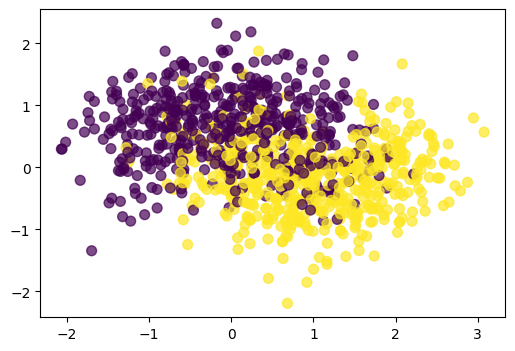

Traditional Bayes Accuracy: 0.7766666666666666
Non-parametyric Bayes Accuracy: 0.7933333333333333
Naive Bayes accuracy: 0.78


In [3]:
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.metrics import accuracy_score
from scipy.stats import multivariate_normal

# Criando dataset 
plt.figure(figsize=(6,4))
n_samples = 1000
data = datasets.make_moons(n_samples=n_samples, noise=.5)
X = data[0]
y = data[1]
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50, alpha=0.7)
plt.show(True)

# Separando atributos e classes da tabela e convertendo para numpy arrays
classes = pd.unique(y)
nrow,ncol = X.shape
p = 0.7 # fracao de elementos no conjunto de treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

# MÉTODO 1: BAYESIANO TRADICIONAL

# Matriz para armazenar as probabilidades
P = pd.DataFrame(data=np.zeros((X_test.shape[0], len(classes))), columns = classes) 
Pc = np.zeros(len(classes)) # Fração de elementos em cada classe
for i in np.arange(0, len(classes)):
    elements = np.array(np.where(y_train == classes[i]))
    Pc[i] = elements.shape[1]/len(y_train)
    Z = X_train[elements,:][0].astype(float)
    m = np.mean(Z, axis = 0)
    cv = np.cov(np.transpose(Z))
    for j in np.arange(0,X_test.shape[0]):
        x = X_test[j,:]
        pj = multivariate_normal.pdf(x, mean=m, cov=cv, allow_singular=True)
        P.loc[j, classes[i]] = pj*Pc[i] # Teorema de Bayes

y_pred = []
for i in np.arange(0, X_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])
y_pred = np.array(y_pred)
y_test = np.array(y_test)

score = accuracy_score(y_pred, y_test)
print('Traditional Bayes Accuracy:', score)
# MÉTODO 2: BAYESIANO NÃO PARAMÉTRICO

# Usando KDE para estimar as densidades (importado do sklearn)
h = 0.162  # parametro de largura de banda
kdes = {}
for c in classes:
    X_c = X_train[y_train == c]
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(X_c)
    kdes[c] = kde

# Prevendo usendo o teorema de Bayes 
y_pred_kde = []
for x in X_test:
    probs = []
    for c in classes:
        # Implementação em código de P(x|c) * P(c)
        log_likelihood = kdes[c].score_samples(x.reshape(1, -1))
        prior = np.sum(y_train == c) / len(y_train)
        probs.append(np.exp(log_likelihood) * prior)
    y_pred_kde.append(classes[np.argmax(probs)])

score_kde = accuracy_score(y_pred_kde, y_test)
print('Non-parametyric Bayes Accuracy:', score_kde)

# MÉTODO 3: MÉTODO DE NAIVE BAYES

def likelihood(x, X_class):
    prob = 1
    for j in range(X_class.shape[1]):
        mean = np.mean(X_class[:, j])
        std = np.std(X_class[:, j])
        prob *= (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-((x[j] - mean) ** 2) / (2 * std ** 2))
    return prob

# Cauculando predições
y_pred_naive = []
for x in X_test:
    probs = []
    for c in classes:
        X_class = X_train[y_train == c]
        # Calculando P(x|c) * P(c)
        prior = np.sum(y_train == c) / len(y_train)
        prob = likelihood(x, X_class) * prior
        probs.append(prob)
    y_pred_naive.append(classes[np.argmax(probs)])

NB_score = accuracy_score(y_pred_naive, y_test)
print('Naive Bayes accuracy:', NB_score)